In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import bisect
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define classes needed for unpickling
class FeatureScorer:
    """Scorer that maps feature values to migraine risk scores [1-10]."""
    
    def __init__(self, edges, pattern):
        self.edges = edges
        self.pattern = pattern
    
    def __call__(self, x):
        """Map value x to risk score using binning and pattern."""
        # Handle edge cases
        if np.isnan(x):
            return 5  # neutral score for missing values
        
        # Find bin index
        idx = bisect.bisect_right(self.edges, x) - 1
        # Clamp to valid range [0, len(pattern)-1]
        idx = max(0, min(len(self.pattern) - 1, idx))
        
        return self.pattern[idx]


class FeatureNormalizer:
    """Normalizer that converts feature values to z-scores based on priors."""
    
    def __init__(self, prior_info):
        self.prior_info = prior_info
        self.dist = prior_info.get('dist', 'normal')
    
    def __call__(self, x):
        """Normalize a value to z-score based on its prior distribution."""
        if self.dist == 'normal':
            mu = self.prior_info['mu']
            sigma = self.prior_info['sigma']
            return (x - mu) / sigma
        
        elif self.dist == 'lognormal':
            mu_ln = self.prior_info['mu_ln']
            sigma_ln = self.prior_info['sigma_ln']
            # For lognormal, normalize in log space
            if x <= 0:
                return -3.0  # Clamp very low values
            return (np.log(x) - mu_ln) / sigma_ln
        
        elif self.dist == 'uniform':
            min_val = self.prior_info['min']
            max_val = self.prior_info['max']
            # Map to [-1, 1] range
            return 2 * (x - min_val) / (max_val - min_val) - 1
        
        else:
            # Default: return as-is
            return x

## 1. Load Data

In [2]:
Path.exists("../data/migraine_features_augmented.csv")

True

In [5]:
# Load augmented features
df_features = pd.read_csv('../data/migraine_features_augmented.csv')
print(f"Loaded {len(df_features)} features")

# Load normalizer
with open('../data/feature_normalizer.pkl', 'rb') as f:
    normalizer = pickle.load(f)

print(f"\nNormalizer contains:")
for key in normalizer.keys():
    print(f"  - {key}")

df_features.head()

Loaded 20 features

Normalizer contains:
  - scorers
  - normalizers
  - priors
  - features
  - categories
  - weights
  - W_feat_to_Z


,category,variable,Description,Weight,min,max,mean,std,Normalized range (1-10),Migraine impact pattern,relevance,bin_edges,bin_centers,Migraine Impact Pattern
0,Sleep,Sleep Duration (hours),Average hours of sleep per night,0.85,4.0,10,7.0,1.2,4-10,Low sleep increases risk,0.85,"[4.0, 4.6, 5.2, 5.8, 6.4, 7.0, 7.6, 8.2, 8.8, ...","[4.3, 4.9, 5.5, 6.1, 6.7, 7.3, 7.8999999999999...","9,8,7,6,5,4,3,3,2,2"
1,Sleep,Sleep Quality (1-10),Self-reported sleep quality,0.80,1.0,10,6.5,1.8,1-10,Poor quality increases risk,0.80,"[1.0, 1.9, 2.8, 3.7, 4.6, 5.5, 6.4, 7.3, 8.2, ...","[1.45, 2.3499999999999996, 3.25, 4.15, 5.05, 5...","9,8,7,6,5,4,3,3,2,2"
2,Sleep,Sleep Consistency Score,Consistency of sleep schedule,0.70,1.0,10,6.0,1.5,1-10,Irregular schedule increases risk,0.70,"[1.0, 1.9, 2.8, 3.7, 4.6, 5.5, 6.4, 7.3, 8.2, ...","[1.45, 2.3499999999999996, 3.25, 4.15, 5.05, 5...","9,8,7,6,5,4,3,3,2,2"
3,Stress,Stress Level (1-10),Self-reported stress level,0.90,1.0,10,6.0,2.0,1-10,High stress increases risk,0.90,"[1.0, 1.9, 2.8, 3.7, 4.6, 5.5, 6.4, 7.3, 8.2, ...","[1.45, 2.3499999999999996, 3.25, 4.15, 5.05, 5...","2,2,3,3,4,5,6,7,8,9"
4,Stress,Work Hours,Hours worked per day,0.75,4.0,16,8.5,2.0,4-16 (normalized),Overwork increases risk,0.75,"[4.0, 5.2, 6.4, 7.6, 8.8, 10.0, 11.2, 12.4, 13...","[4.6, 5.800000000000001, 7.0, 8.2, 9.4, 10.6, ...","3,3,4,4,5,5,6,6,7,7"


## 2. Visualize Impact Patterns

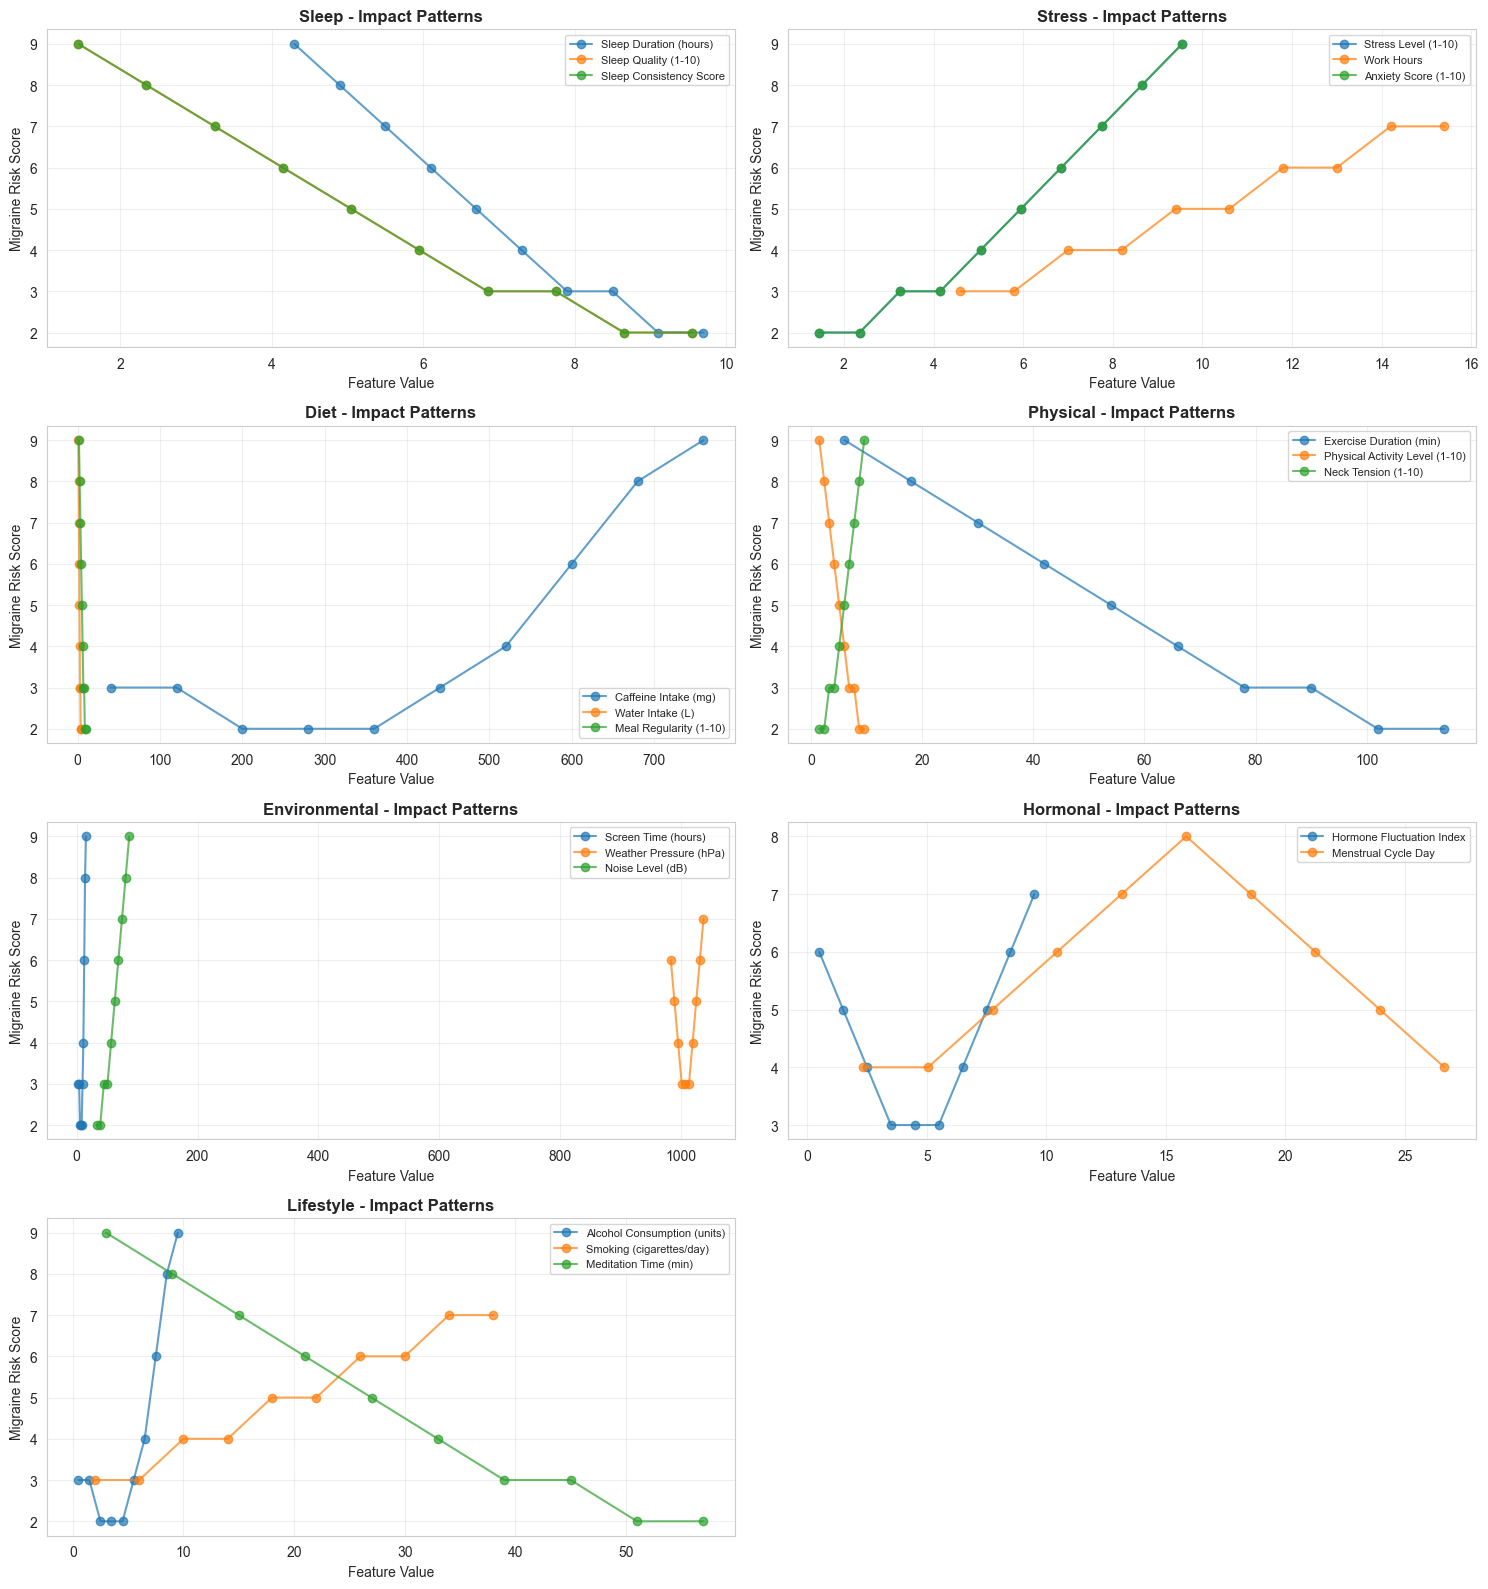

✓ Saved impact patterns visualization


In [6]:
# Plot impact patterns for each category
categories = df_features['category'].unique()

fig, axes = plt.subplots(4, 2, figsize=(15, 16))
axes = axes.flatten()

for i, category in enumerate(categories):
    ax = axes[i]
    
    # Get features in this category
    cat_features = df_features[df_features['category'] == category]
    
    for _, row in cat_features.iterrows():
        pattern = [int(x) for x in row['Migraine Impact Pattern'].split(',')]
        bin_centers = json.loads(row['bin_centers'])
        
        ax.plot(bin_centers, pattern, marker='o', label=row['variable'], alpha=0.7)
    
    ax.set_title(f'{category} - Impact Patterns', fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Migraine Risk Score')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('../data/impact_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved impact patterns visualization")

## 3. Prior Distributions

C:\Users\user\AppData\Local\Temp\ipykernel_41776\222124229.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7)


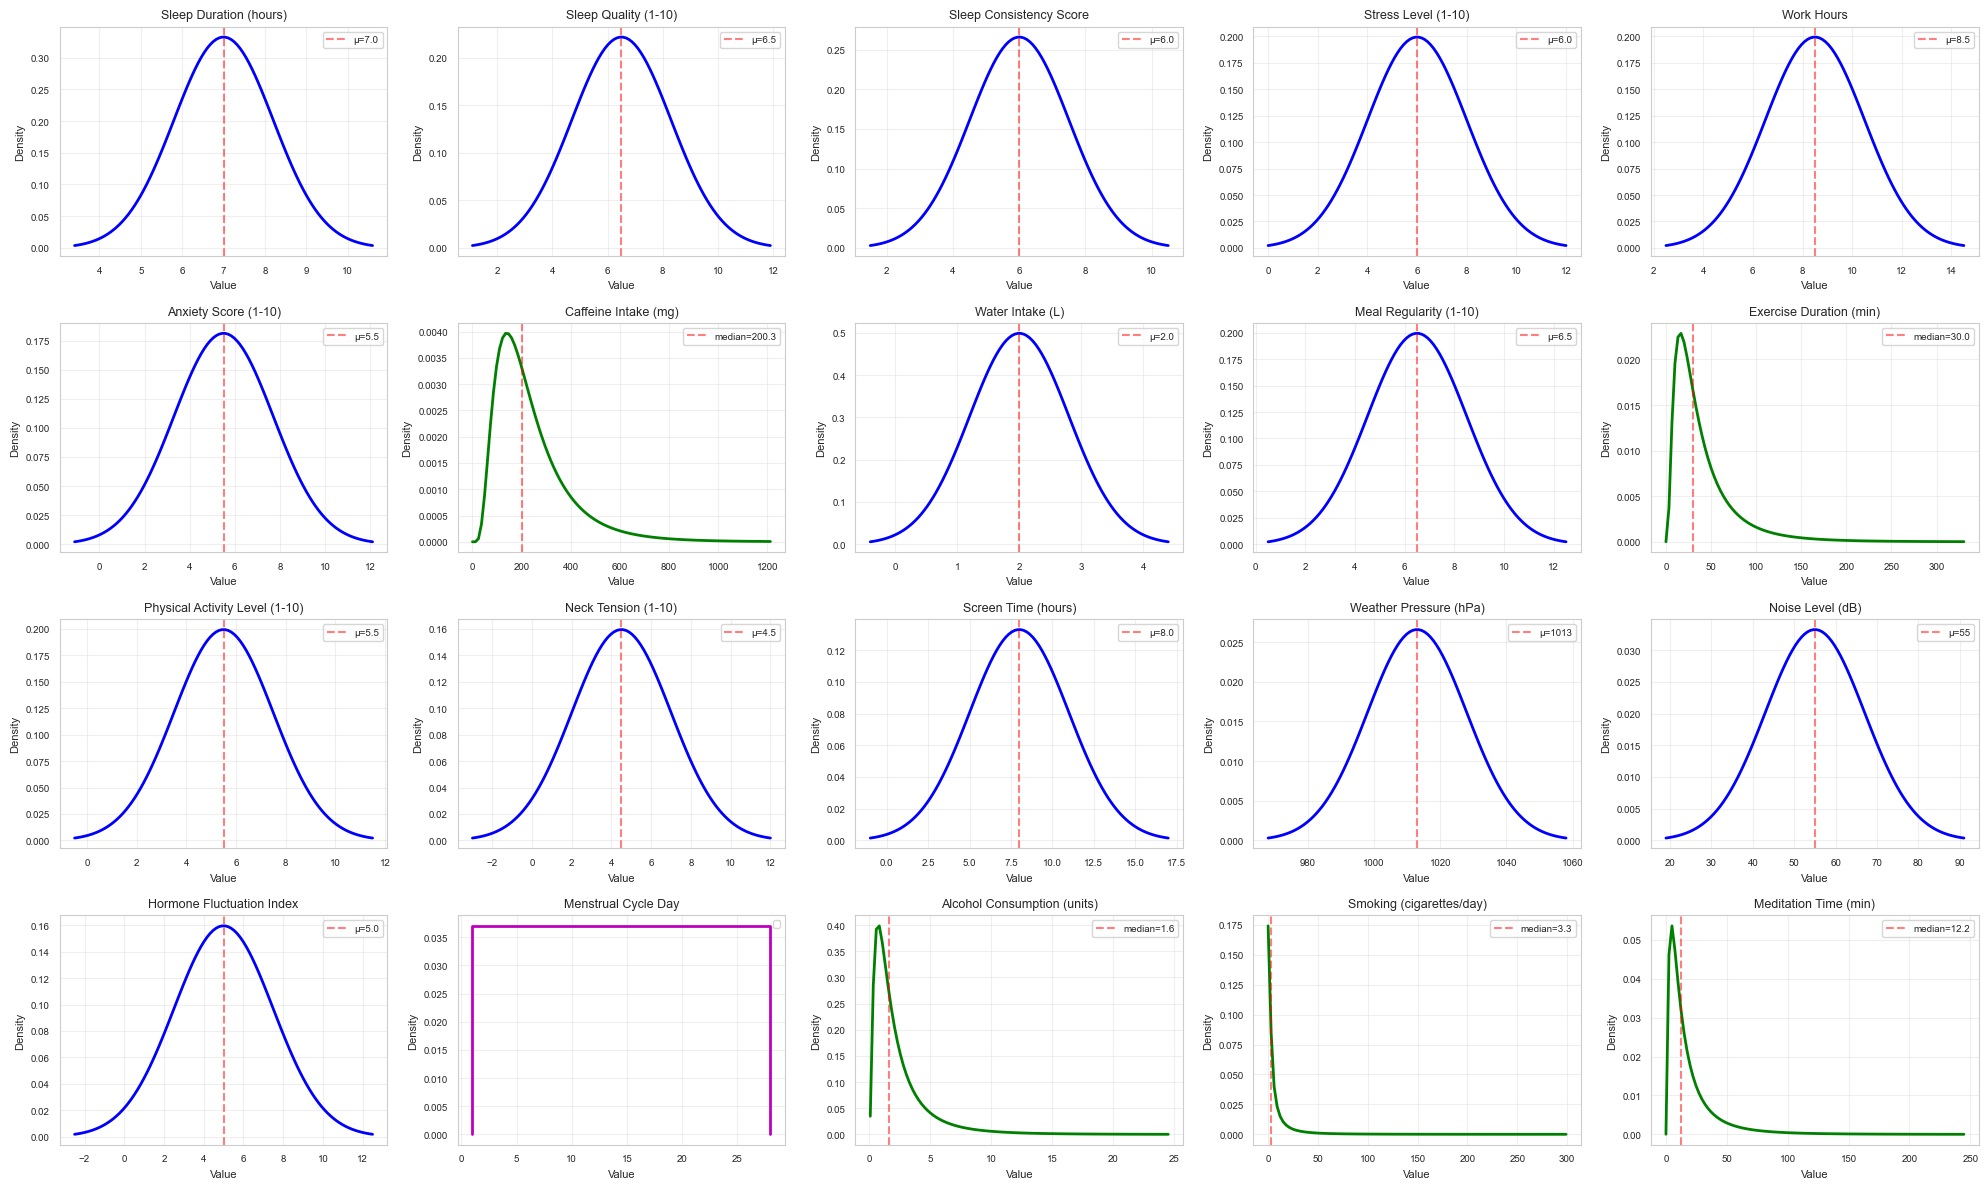

✓ Saved prior distributions visualization


In [7]:
# Visualize prior distributions
priors = normalizer['priors']

fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()

for i, (var_name, prior_info) in enumerate(priors.items()):
    ax = axes[i]
    
    dist = prior_info.get('dist', 'normal')
    
    if dist == 'normal':
        mu = prior_info['mu']
        sigma = prior_info['sigma']
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        y = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu)/sigma)**2)
        ax.plot(x, y, 'b-', linewidth=2)
        ax.axvline(mu, color='r', linestyle='--', alpha=0.5, label=f'μ={mu}')
        
    elif dist == 'lognormal':
        mu_ln = prior_info['mu_ln']
        sigma_ln = prior_info['sigma_ln']
        x = np.linspace(0.1, np.exp(mu_ln + 3*sigma_ln), 100)
        y = (1/(x * sigma_ln * np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(x)-mu_ln)/sigma_ln)**2)
        ax.plot(x, y, 'g-', linewidth=2)
        ax.axvline(np.exp(mu_ln), color='r', linestyle='--', alpha=0.5, label=f'median={np.exp(mu_ln):.1f}')
        
    elif dist == 'uniform':
        min_val = prior_info['min']
        max_val = prior_info['max']
        x = np.array([min_val, min_val, max_val, max_val])
        y = np.array([0, 1/(max_val-min_val), 1/(max_val-min_val), 0])
        ax.plot(x, y, 'm-', linewidth=2)
    
    ax.set_title(var_name, fontsize=9)
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.tick_params(labelsize=7)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/prior_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved prior distributions visualization")

## 4. Risk Weight Matrix

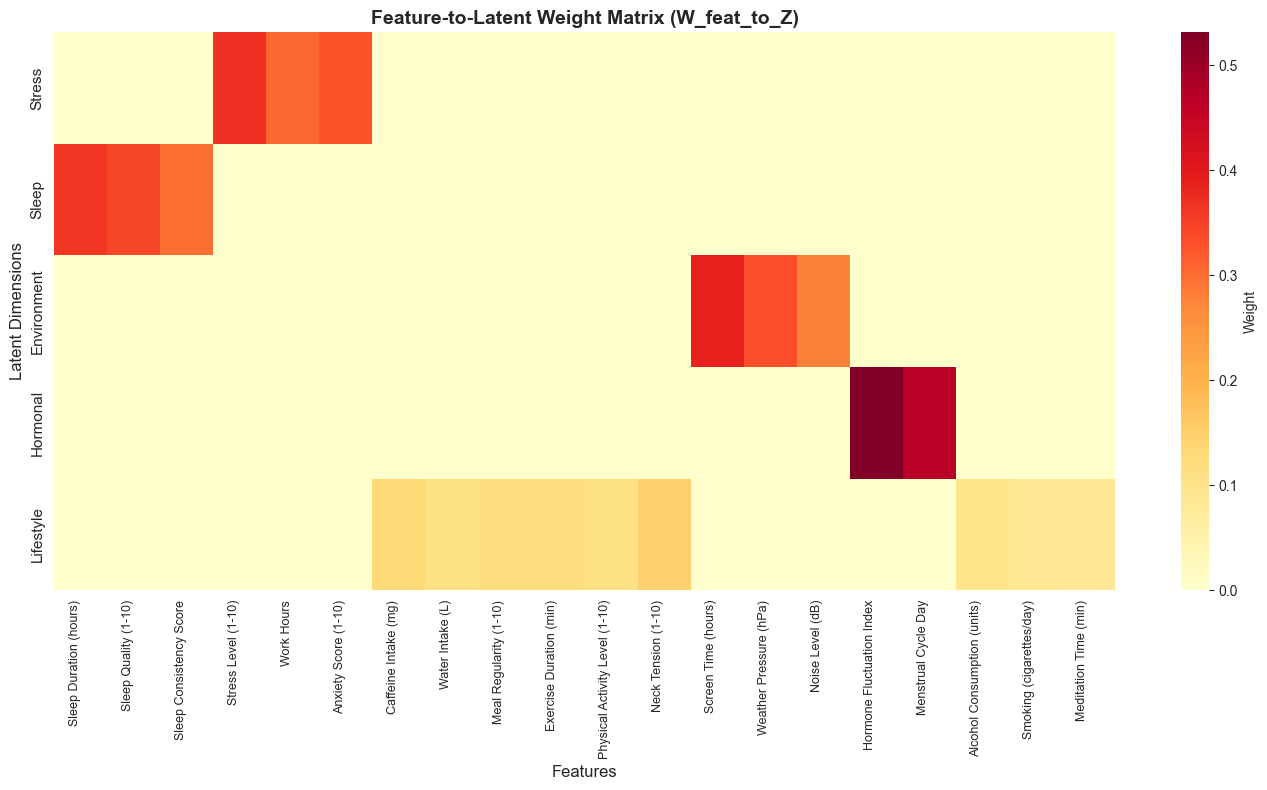

✓ Saved weight matrix visualization

Matrix shape: (5, 20)
Non-zero weights per latent dimension: [3, 3, 3, 2, 9]


In [8]:
# Visualize risk weight matrix W_feat_to_Z
W = normalizer['W_feat_to_Z']
features = normalizer['features']

latent_names = ['Stress', 'Sleep', 'Environment', 'Hormonal', 'Lifestyle']

plt.figure(figsize=(14, 8))
sns.heatmap(W, 
            xticklabels=features, 
            yticklabels=latent_names,
            cmap='YlOrRd', 
            annot=False, 
            fmt='.2f',
            cbar_kws={'label': 'Weight'})

plt.title('Feature-to-Latent Weight Matrix (W_feat_to_Z)', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Latent Dimensions', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=9)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('../data/weight_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved weight matrix visualization")
print(f"\nMatrix shape: {W.shape}")
print(f"Non-zero weights per latent dimension: {(W > 0).sum(axis=1).tolist()}")

## 5. Test Normalizer on Sample Data

In [9]:
# Test scorer and normalizer on sample values
scorers = normalizer['scorers']
normalizers = normalizer['normalizers']

print("Testing normalizer on sample values:\n")
print("=" * 80)

# Test a few features with their mean, low, and high values
test_features = [
    'Sleep Duration (hours)',
    'Stress Level (1-10)',
    'Caffeine Intake (mg)',
    'Exercise Duration (min)',
]

for var_name in test_features:
    row = df_features[df_features['variable'] == var_name].iloc[0]
    
    min_val = row['min']
    mean_val = row['mean']
    max_val = row['max']
    
    scorer = scorers[var_name]
    normalizer_fn = normalizers[var_name]
    
    print(f"\n{var_name}:")
    print(f"  Range: [{min_val}, {max_val}]")
    
    for label, val in [('Min', min_val), ('Mean', mean_val), ('Max', max_val)]:
        score = scorer(val)
        norm = normalizer_fn(val)
        print(f"  {label:6s} = {val:6.1f}  →  Risk Score: {score:2d}/10  |  Normalized: {norm:+6.3f}")

print("\n" + "=" * 80)

Testing normalizer on sample values:


Sleep Duration (hours):
  Range: [4.0, 10]
  Min    =    4.0  →  Risk Score:  9/10  |  Normalized: -2.500
  Mean   =    7.0  →  Risk Score:  4/10  |  Normalized: +0.000
  Max    =   10.0  →  Risk Score:  2/10  |  Normalized: +2.500

Stress Level (1-10):
  Range: [1.0, 10]
  Min    =    1.0  →  Risk Score:  2/10  |  Normalized: -2.500
  Mean   =    6.0  →  Risk Score:  5/10  |  Normalized: +0.000
  Max    =   10.0  →  Risk Score:  9/10  |  Normalized: +2.000

Caffeine Intake (mg):
  Range: [0.0, 800]
  Min    =    0.0  →  Risk Score:  3/10  |  Normalized: -3.000
  Mean   =  200.0  →  Risk Score:  2/10  |  Normalized: -0.003
  Max    =  800.0  →  Risk Score:  9/10  |  Normalized: +2.308

Exercise Duration (min):
  Range: [0.0, 120]
  Min    =    0.0  →  Risk Score:  9/10  |  Normalized: -3.000
  Mean   =   30.0  →  Risk Score:  7/10  |  Normalized: +0.001
  Max    =  120.0  →  Risk Score:  2/10  |  Normalized: +1.734



## 6. Category-wise Weight Distribution

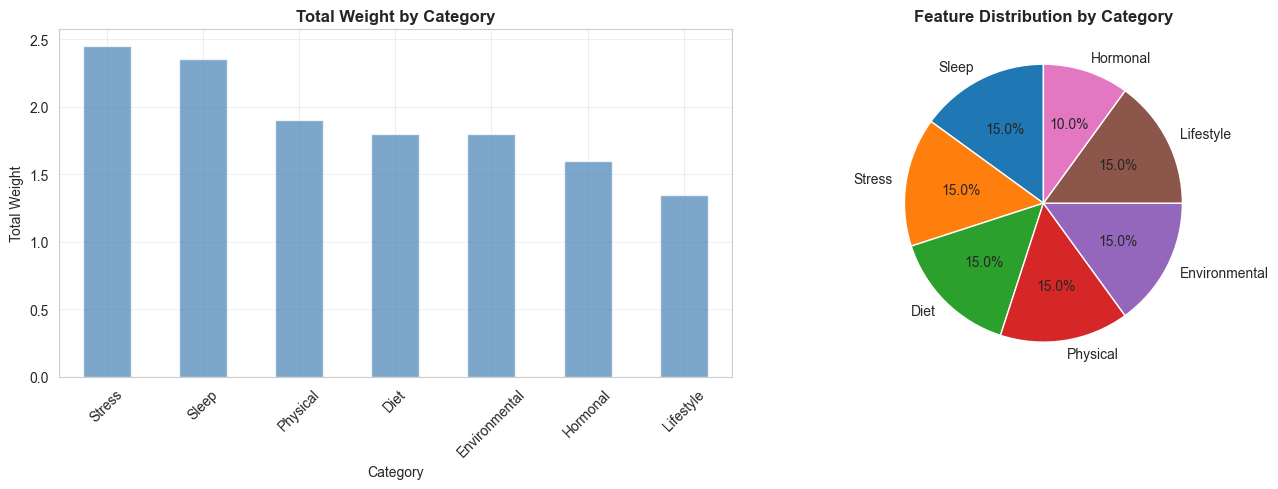


Category Summary:
                   mean   sum  count
category                            
Stress         0.816667  2.45      3
Sleep          0.783333  2.35      3
Physical       0.633333  1.90      3
Diet           0.600000  1.80      3
Environmental  0.600000  1.80      3
Hormonal       0.800000  1.60      2
Lifestyle      0.450000  1.35      3


In [10]:
# Visualize feature weights by category
category_weights = df_features.groupby('category')['Weight'].agg(['mean', 'sum', 'count'])
category_weights = category_weights.sort_values('sum', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of total weights
category_weights['sum'].plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.7)
axes[0].set_title('Total Weight by Category', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Total Weight')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Pie chart of feature count
category_counts = df_features['category'].value_counts()
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Feature Distribution by Category', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/category_weights.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCategory Summary:")
print(category_weights)

## Summary

This notebook validates the feature normalization system created in Ticket 003:

✅ **Impact Patterns**: Visualized risk scores across feature ranges

✅ **Prior Distributions**: Showed population-level distributions for all features

✅ **Weight Matrix**: Mapped features to latent dimensions

✅ **Normalizer Testing**: Validated scoring and normalization functions

**Next Steps**:
- Use `feature_normalizer.pkl` in Ticket 004 (Simulator)
- Integrate with ALINE pretraining pipeline
- Apply to real-world data collection